In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [2]:
import keras
from keras.applications import MobileNetV3Small, EfficientNetV2B0
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

In [3]:
# 訓練データと検証データのジェネレータ
train_generator, validation_generator = keras.utils.image_dataset_from_directory(
    '../move_window_scene',  # 画像データが格納されているディレクトリ
    image_size=(520, 570),
    batch_size=32,
    validation_split=0.2,
    subset="both",
    seed=1337,
)

Found 38 files belonging to 2 classes.
Using 31 files for training.
Using 7 files for validation.


In [4]:
# MobileNetV3モデルの読み込み（事前学習済みの重みを使用）
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(520, 570, 3))

# カスタム分類層の追加
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# モデルの構築
model = Model(inputs=base_model.input, outputs=predictions)

# 基本モデルの層を固定（事前学習済みの重みを変更しない）
for layer in base_model.layers:
    layer.trainable = False

# モデルのコンパイル
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# モデルの学習
model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# 固定した層を解除して再学習（ファインチューニング）
for layer in base_model.layers:
    layer.trainable = True

# 再度コンパイル
model.compile(optimizer=keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# ファインチューニングの学習
model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.2903 - loss: 0.7919 - val_accuracy: 0.8571 - val_loss: 0.5321
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.5053 - val_accuracy: 1.0000 - val_loss: 0.3753
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.3187 - val_accuracy: 1.0000 - val_loss: 0.2658
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9677 - loss: 0.2181 - val_accuracy: 1.0000 - val_loss: 0.1967
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.1462 - val_accuracy: 1.0000 - val_loss: 0.1519
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0997 - val_accuracy: 1.0000 - val_loss: 0.1197
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0772 - val_accuracy: 1.0000 - val_loss: 0.0961
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0494 - val_accuracy: 1.0000 - val_loss: 0.0788
Epoch 9/10
1/1 ━

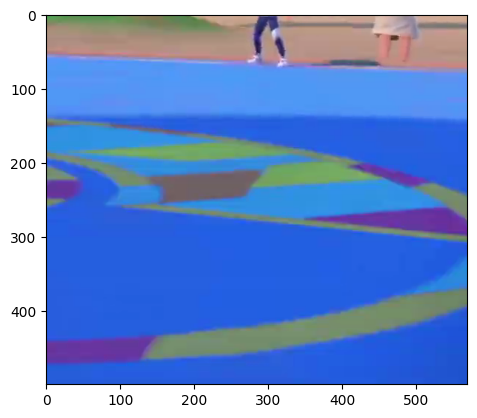

In [25]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread('../move_window_scene/negative/20240514140951.png')

plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.show()

In [11]:
import numpy as np

# 画像のパス
img_path = '../move_window_scene/positive/20240514133811.png'
img = keras.utils.load_img(img_path, target_size=(520, 570))
img_array = keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
predictions = model.predict(img_array)

print(f'Predicted class: {"技選択画面である" if predictions[0] > 0.5 else "技選択画面でない"}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Predicted class: 技選択画面である


In [24]:
predictions

array([[0.98478234]], dtype=float32)

In [27]:
model.save('move_scene_detect_model.keras')

In [30]:
(0.05*100000) / 60

83.33333333333333

5フレームに1枚を推論するならなんとかなるか...？